# Feature Engineering Project - Fall 2022
# Gold Price Prediction
Submitted By :
1. Yash Zauwar
2. Goutham Pallapothu
3. Veeranjaneyulu Muppalla
4. Sai Manideep Reddy Pallerla

# 1. Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import figure_factory as figfac
from termcolor import colored
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
from sklearn.metrics import mean_squared_error
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

import warnings
warnings.filterwarnings("ignore")

C:\Users\yashz\AppData\Local\Temp\ipykernel_23260\744351177.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


# 2. Preprocessing the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data

start = '2000-01-01'
end = '2022-11-01'

df = data.DataReader('GLD','yahoo',start,end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-11-18,44.490002,44.070000,44.430000,44.380001,5992000,44.380001
2004-11-19,44.919998,44.470001,44.490002,44.779999,11655300,44.779999
2004-11-22,44.970001,44.740002,44.750000,44.950001,11996000,44.950001
2004-11-23,44.919998,44.720001,44.880001,44.750000,3169200,44.750000
2004-11-24,45.049999,44.790001,44.930000,45.049999,6105100,45.049999


In [3]:
df.info() #printing the dataframe info

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4520 entries, 2004-11-18 to 2022-11-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       4520 non-null   float64
 1   Low        4520 non-null   float64
 2   Open       4520 non-null   float64
 3   Close      4520 non-null   float64
 4   Volume     4520 non-null   int64  
 5   Adj Close  4520 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 247.2 KB


In [4]:
df.describe() # describe the data

,High,Low,Open,Close,Volume,Adj Close
count,4520.000000,4520.000000,4520.000000,4520.000000,4.520000e+03,4520.000000
mean,119.310768,118.085945,118.723460,118.719071,9.686055e+06,118.719071
std,37.669187,37.387078,37.542858,37.535528,6.950361e+06,37.535528
min,41.360001,41.020000,41.029999,41.259998,3.193000e+05,41.259998
25%,93.677498,92.372498,93.017500,93.082497,5.320800e+06,93.082497
50%,121.349998,120.415001,120.844997,120.834999,8.044900e+06,120.834999
75%,150.380005,148.607506,149.652496,149.470005,1.194095e+07,149.470005
max,194.449997,192.520004,193.740005,193.889999,9.380420e+07,193.889999


In [5]:
df #print the dataset

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-11-18,44.490002,44.070000,44.430000,44.380001,5992000,44.380001
2004-11-19,44.919998,44.470001,44.490002,44.779999,11655300,44.779999
2004-11-22,44.970001,44.740002,44.750000,44.950001,11996000,44.950001
2004-11-23,44.919998,44.720001,44.880001,44.750000,3169200,44.750000
2004-11-24,45.049999,44.790001,44.930000,45.049999,6105100,45.049999
...,...,...,...,...,...,...
2022-10-26,155.729996,154.779999,154.779999,154.979996,4448200,154.979996
2022-10-27,155.089996,154.220001,154.710007,154.740005,3654900,154.740005
2022-10-28,153.539993,152.500000,152.960007,153.160004,4645400,153.160004


In [6]:
df.rename(columns = {"Date" : "date", "Open" : "open", "High" : "high", "Low" : "low","Close" : "close", "Volume" : "volume", "Currency" : "currency"}, inplace = True)
#renaming the data frame columns to lower case

# 3. Feature Engineering

In [7]:
features_na = [features for features in df.columns if df[features].isnull().sum() > 0]
for feature in features_na:
    print(feature, np.round(df[feature].isnull().mean(), 4),  ' % missing values')
else:
    print("No missing value found")

No missing value found


In [8]:
for column in df.columns:
    print(column,df[column].nunique())

high 3608
low 3614
open 3624
close 3606
volume 4453
Adj Close 3606


In [9]:
categorical_features=[feature for feature in df.columns if ((df[feature].dtypes=='O') & (feature not in ['GLD']))]
categorical_features

[]

In [10]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(df[feature].unique())))

In [12]:
# list of numerical variables
numerical_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['GLD']))]
print('Number of numerical variables: ', len(numerical_features))

# visualise the numerical variables
df[numerical_features].head()

Number of numerical variables:  6


,high,low,open,close,volume,Adj Close
Date,,,,,,
2004-11-18,44.490002,44.070000,44.430000,44.380001,5992000,44.380001
2004-11-19,44.919998,44.470001,44.490002,44.779999,11655300,44.779999
2004-11-22,44.970001,44.740002,44.750000,44.950001,11996000,44.950001
2004-11-23,44.919998,44.720001,44.880001,44.750000,3169200,44.750000
2004-11-24,45.049999,44.790001,44.930000,45.049999,6105100,45.049999


In [14]:
discrete_feature=[feature for feature in numerical_features if len(df[feature].unique())<25]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 0


In [16]:
continuous_features=[feature for feature in numerical_features if feature not in discrete_feature+['GOD']]
print("Continuous feature Count {}".format(len(continuous_features)))

Continuous feature Count 6


In [17]:
print("Shape of the dataset: ", df.shape)
print("Length of the dataset: ", len(df))
print("Maximum closing price of gold during last twenty two years: ", df["close"].max())
print("Minimum closing price of gold during last twenty two years: ", df["close"].min())

Shape of the dataset:  (4520, 6)
Length of the dataset:  4520
Maximum closing price of gold during last twenty two years:  193.88999938964844
Minimum closing price of gold during last twenty two years:  41.2599983215332


# 4. Exploratory Data Analysis

In [18]:
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for discrete_feature in discrete_feature:
    ax = plt.subplot(12,3,plotnumber)
    sns.distplot(df[discrete_feature])
    plt.xlabel(discrete_feature)
    plotnumber+=1
plt.show()

<Figure size 2000x6000 with 0 Axes>

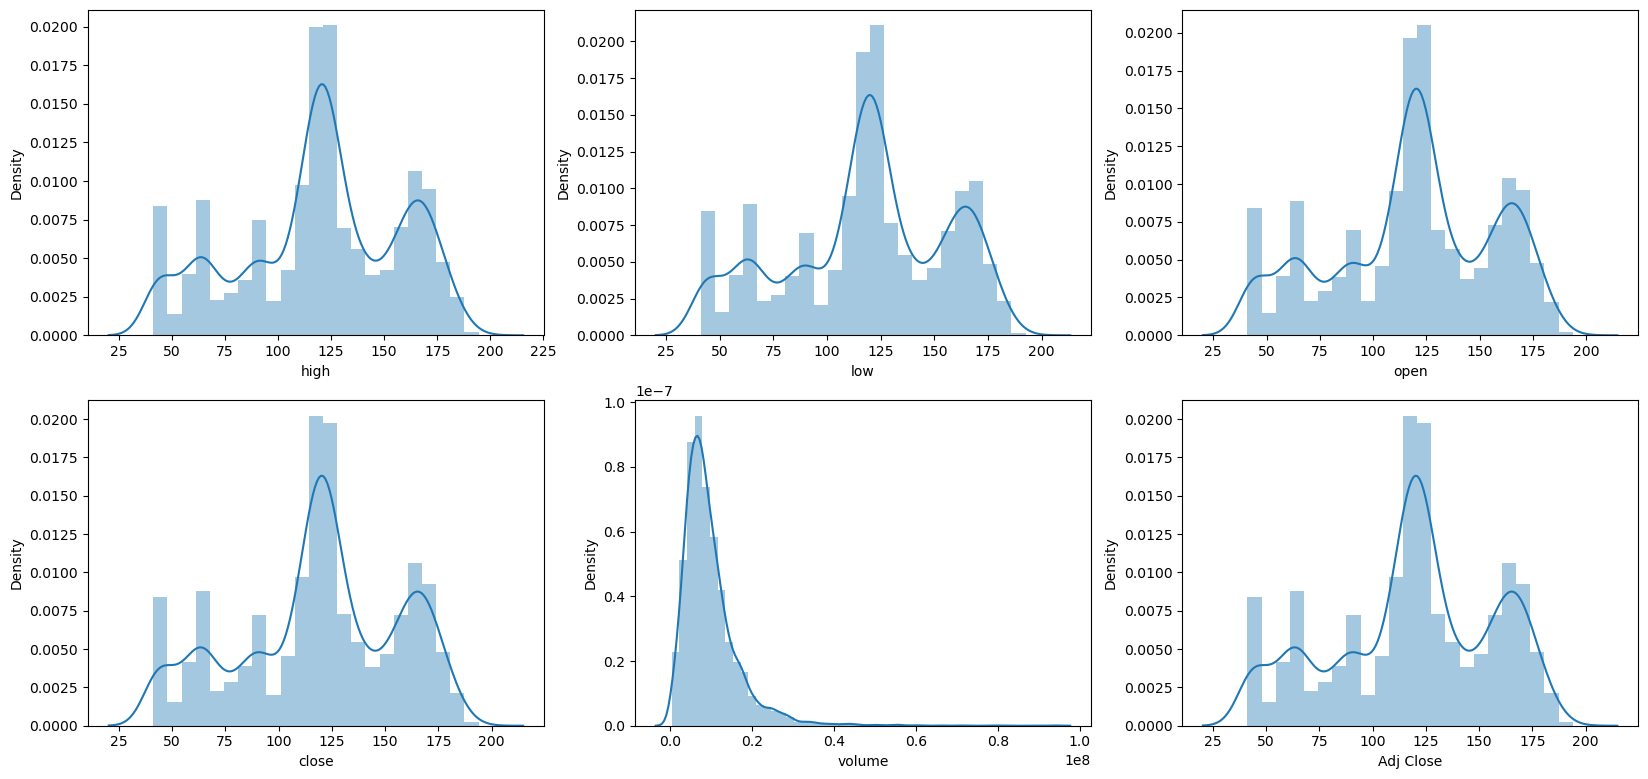

In [19]:
#plot a univariate distribution of continues observations
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for continuous_feature in continuous_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.distplot(df[continuous_feature])
    plt.xlabel(continuous_feature)
    plotnumber+=1
plt.show()

# Correlation between dataframe columns

In [20]:
corr = df.corr()

In [21]:
corr

,high,low,open,close,volume,Adj Close
high,1.000000,0.999755,0.999863,0.999850,0.264942,0.999850
low,0.999755,1.000000,0.999818,0.999865,0.250115,0.999865
open,0.999863,0.999818,1.000000,0.999710,0.259176,0.999710
close,0.999850,0.999865,0.999710,1.000000,0.256708,1.000000
volume,0.264942,0.250115,0.259176,0.256708,1.000000,0.256708
Adj Close,0.999850,0.999865,0.999710,1.000000,0.256708,1.000000


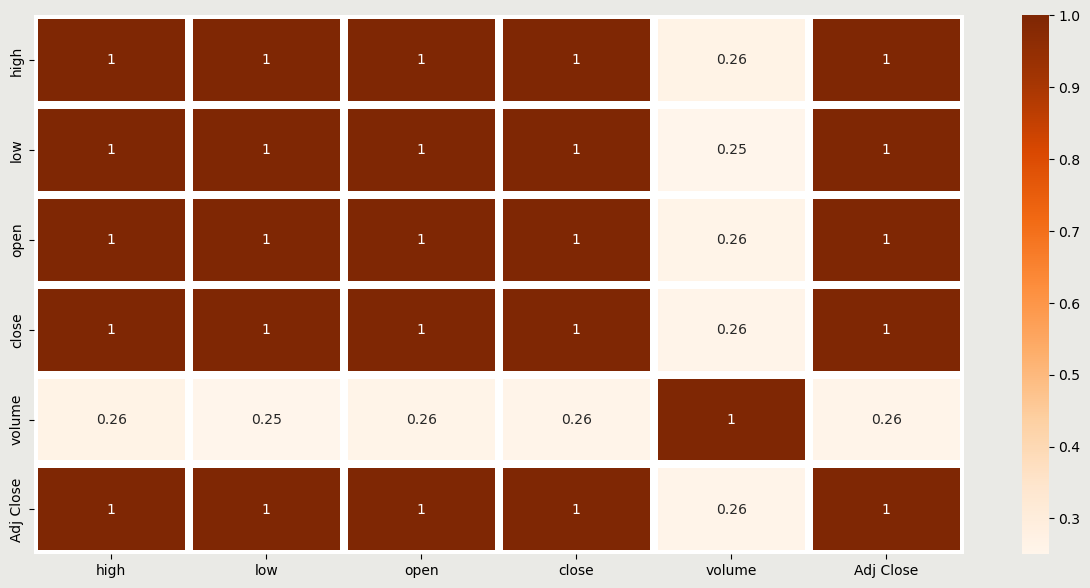

In [22]:
plt.figure(figsize = [15, 7], clear = True, facecolor = '#EAEAE6')
sns.heatmap(df.corr(), annot = True, square = False, linewidths = 5,
            linecolor = "white", cmap = "Oranges");

In [23]:
print (corr['close'].sort_values(ascending=False), '\n')

close        1.000000
Adj Close    1.000000
low          0.999865
high         0.999850
open         0.999710
volume       0.256708
Name: close, dtype: float64 



In [24]:
data = df.filter(['close'])

In [25]:
data

,close
Date,
2004-11-18,44.380001
2004-11-19,44.779999
2004-11-22,44.950001
2004-11-23,44.750000
2004-11-24,45.049999
...,...
2022-10-26,154.979996
2022-10-27,154.740005
2022-10-28,153.160004


In [26]:
df2=df.copy()

In [27]:
df2.head()

,high,low,open,close,volume,Adj Close
Date,,,,,,
2004-11-18,44.490002,44.070000,44.430000,44.380001,5992000,44.380001
2004-11-19,44.919998,44.470001,44.490002,44.779999,11655300,44.779999
2004-11-22,44.970001,44.740002,44.750000,44.950001,11996000,44.950001
2004-11-23,44.919998,44.720001,44.880001,44.750000,3169200,44.750000
2004-11-24,45.049999,44.790001,44.930000,45.049999,6105100,45.049999


# Splitting the Data to Training and Testing

In [28]:
X = df2.drop(['close'],axis=1)
y = df2['close']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [30]:
len(X_train)

3616

In [32]:
len(X_test)

904

In [33]:
dataset = data.values
dataset[0:5]

array([[44.38000107],
       [44.77999878],
       [44.95000076],
       [44.75      ],
       [45.04999924]])

In [34]:
training_data_len = int(np.ceil( len(dataset) * .95 ))
print("Training data length: ", training_data_len)

Training data length:  4294


# Scaling the Data

In [35]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.02044161],
       [0.02306231],
       [0.02417613],
       ...,
       [0.73314555],
       [0.72495581],
       [0.7351111 ]])

In [36]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train, "\n")
        print(y_train)

[array([2.04416086e-02, 2.30623104e-02, 2.41761280e-02, 2.28657646e-02,
       2.48312972e-02, 2.64037382e-02, 2.71244393e-02, 2.52899206e-02,
       2.69934005e-02, 2.41761280e-02, 2.84347777e-02, 2.56175052e-02,
       2.52244137e-02, 1.80174276e-02, 1.65105185e-02, 1.42829083e-02,
       1.73622585e-02, 1.50036094e-02, 1.78864138e-02, 1.58553493e-02,
       1.91967522e-02, 2.01795310e-02, 1.93933229e-02, 1.80829596e-02,
       1.97209075e-02, 2.10967778e-02, 2.03760767e-02, 1.57243105e-02,
       1.68381281e-02, 1.66415573e-02, 1.15311677e-02, 9.69667396e-03,
       9.23802554e-03, 5.83111576e-03, 3.80005128e-03, 4.52075239e-03,
       6.22420727e-03, 8.77940210e-03, 8.77940210e-03, 6.94490838e-03,
       6.94490838e-03, 6.55179187e-03, 6.48628495e-03, 9.69667396e-03,
       9.89321972e-03, 6.42077803e-03, 9.36906437e-03, 8.91044094e-03,
       9.36906437e-03, 6.28973919e-03, 5.50350617e-03, 5.89662268e-03,
       2.75176558e-03, 1.37589529e-03, 6.55319148e-05, 0.00000000e+00,
     

In [37]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [38]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("The shape of x_train set:", x_train.shape)

The shape of x_train set: (4234, 60, 1)


# Machine Learning Model

In [39]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = "adam", loss = "mean_squared_error")

model.fit(x_train, y_train, batch_size = 1, epochs = 1)

4234/4234 [==============================] - 98s 22ms/step - loss: 8.2810e-04


In [40]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [41]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Predictions using the Model Trained Above

In [43]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions[0:10]

8/8 [==============================] - 0s 25ms/step


array([[162.91466],
       [162.57162],
       [162.5108 ],
       [162.68079],
       [162.21852],
       [162.08615],
       [162.85574],
       [163.36392],
       [163.32738],
       [163.14395]], dtype=float32)

In [44]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("RMSE score of the model:", rmse)

RMSE score of the model: 4.409268565821518


# Plotting the Data after applying the model to the testing data.

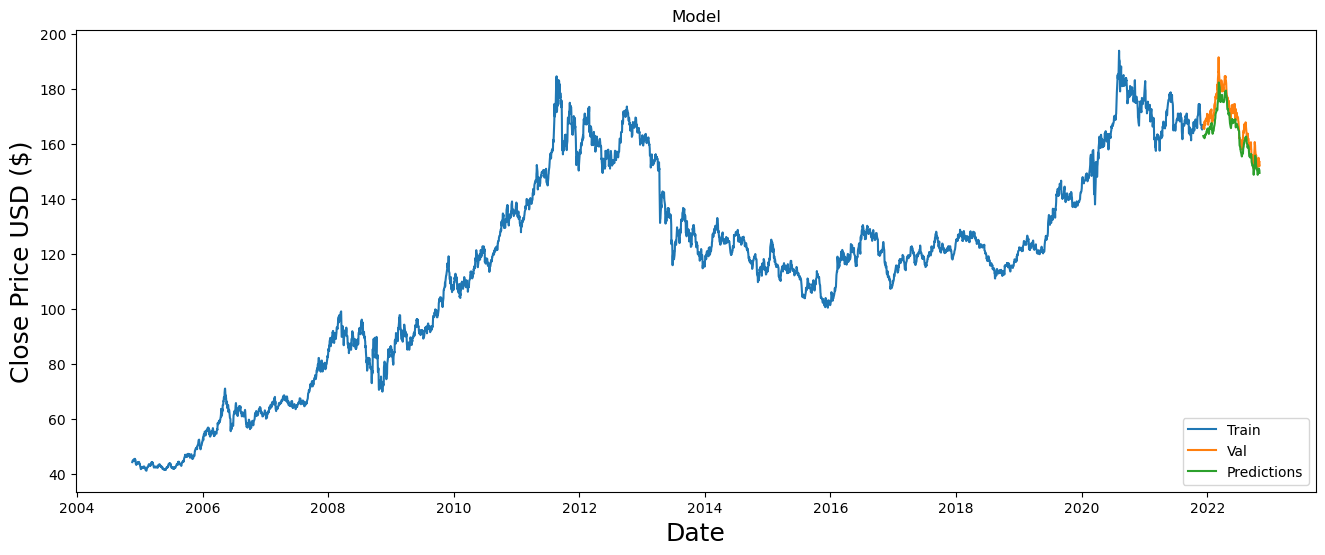

In [45]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()